####CENTROID DATA TO GET AXES SUBSET

In [2]:
category = "Nature"

In [3]:
DIR = "/Users/damoncrockett/Desktop/cities_20k/yahoo/NEW_Clusters/Clusters_Normalized/"

In [4]:
DATA = DIR+"Normalized_Clustered/50/cluster_characterization_"+category+".csv"

In [5]:
import pandas as pd
centroids = pd.read_csv(DATA)
del centroids['Unnamed: 0']

####CATEGORY DATA TO GET IMAGE SUBSET

In [6]:
DATA = DIR+"Normalized_Cluster_Labels/50/"+category+".csv"

In [7]:
images = pd.read_csv(DATA)

####ADD LOCAL PATHS TO FULL METADATA

In [9]:
BASE = "/Users/damoncrockett/Desktop/cities_20k/"

In [10]:
import glob
import os

In [13]:
for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    tmp = pd.read_csv(file)
    n = len(tmp.index)
    local_path = []
    for i in range(n):
        local_path.append(BASE+os.path.basename(file).split("_")[0]+"_20k/"+tmp.ad_id.loc[i]+".jpg")
    tmp['local_path'] = local_path
    tmp.to_csv(file,index=False)

####SUBSET FULL DATA BY AXES AND IMAGES

In [11]:
counter=-1

for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    counter+=1
    tmp = pd.read_csv(file)
    columns = list(centroids.columns.values)
    columns.append("local_path")
    tmp = tmp[columns]
    if counter==0:
        collection = tmp
    else:
        collection = collection.append(tmp)

In [12]:
image_subset = list(set(list(images.local_path)))
collection = collection[collection.local_path.isin(image_subset)]

In [13]:
collection.reset_index(drop=True,inplace=True)

In [14]:
num_cols = len(collection.columns)

####PROJECTION TO 2D

In [15]:
from sklearn.decomposition import RandomizedPCA as pca
from sklearn.manifold import TSNE as tsne

#pca = pca(n_components=2)
tsne = tsne(n_components=2)

X = collection.iloc[:,0:num_cols-1].as_matrix()

#pca.fit(X)
tsne.fit(X)

In [25]:
#subspace_pca = pd.DataFrame(pca.transform(X),columns=["x","y"])
subspace_tsne = pd.DataFrame(tsne.fit_transform(X),columns=["x","y"])

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
#x = subspace_pca.x
#y = subspace_pca.y
#fig, ax = plt.subplots(figsize=(4,4))
#ax.scatter(x, y)

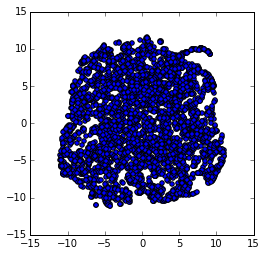

In [27]:
x = subspace_tsne.x
y = subspace_tsne.y
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

####MINIMIZE GRID

In [28]:
import numpy as np

In [39]:
def check_duplicates(num_bins):
    x = list(pd.cut(subspace_tsne['x'],num_bins,labels=False))
    y = list(pd.cut(subspace_tsne['y'],num_bins,labels=False))
    tmp = pd.DataFrame(x)
    tmp['y'] = y
    n = np.mean(tmp.duplicated())
    return n

In [47]:
num_bins = 2
while check_duplicates(num_bins) > 0.1:
    num_bins+=1
print num_bins

233


In [31]:
num_bins_down = num_bins

In [32]:
def check_duplicates_x(num_bins_down):
    x = list(pd.cut(subspace_tsne['x'],num_bins_down,labels=False))
    y = list(pd.cut(subspace_tsne['y'],num_bins,labels=False))
    tmp = pd.DataFrame(x)
    tmp['y'] = y
    n = np.mean(tmp.duplicated())
    return n

In [33]:
def check_duplicates_y(num_bins_down):
    x = list(pd.cut(subspace_tsne['x'],num_bins,labels=False))
    y = list(pd.cut(subspace_tsne['y'],num_bins_down,labels=False))
    tmp = pd.DataFrame(x)
    tmp['y'] = y
    n = np.mean(tmp.duplicated())
    return n

In [34]:
while check_duplicates_x(num_bins_down) == 0:
    num_bins_down -= 1
print num_bins_down

4161


In [35]:
while check_duplicates_y(num_bins_down) == 0:
    num_bins_down -= 1
print num_bins_down

4161


####BIN

In [36]:
num_bins = 4162

In [37]:
subspace_tsne['grid_x'] = pd.cut(subspace_tsne['x'],num_bins,labels=False)
subspace_tsne['grid_y'] = pd.cut(subspace_tsne['y'],num_bins,labels=False)

####ADD PATHS

In [38]:
subspace_tsne['local_path'] = collection.local_path

##THE WALKBACK

The idea is simple: now that the images all have unique grid squares, we want to have them 'walk back' to the center of mass so that we have one clump of images, organized by similarity, as close to the t-SNE coordinates as we can while nonetheless having a large clump of images. Within this simple thought are a million variations, however, and we can imagine they might have a big impact on the resulting plot.

For one thing, we want the images to walk on a straight line back to the center of mass. This can be accomplished by having each image move to the open adjacent square nearest the center of mass. Also, images should stop walking when moving again would put them further from the center of mass. Also, images should take turns starting with those closest to the center of mass.

####PLOT

In [77]:
n = len(subspace_tsne.index)

In [78]:
from PIL import Image

In [79]:
thumb_side = 64

In [80]:
grid_side = num_bins

In [81]:
px_w = thumb_side * grid_side
px_h = thumb_side * grid_side

In [82]:
canvas = Image.new('RGB',(px_w,px_h),(50,50,50))

In [83]:
for i in range(n):
    im = Image.open(subspace_tsne.local_path.loc[i])
    im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
    x = subspace_tsne.grid_x.loc[i] * thumb_side
    y = subspace_tsne.grid_y.loc[i] * thumb_side
    canvas.paste(im,(x,y))

In [84]:
canvas.save("/Users/damoncrockett/Desktop/gridsnap_stack/Nature_tsne_"+str(num_bins)+".png")